# Probability map of phytoplankton in the North Sea using DIVAnd and a neural network
The first step is to load the required modules

In [2]:
using DIVAnd
using DIVAndNN
using LinearAlgebra
using Statistics
using Random
using Dates

The domain and the directory path `datadir` is defined in the file `emodnet_bio_grid.jl`

In [3]:
include("../scripts/emodnet_bio_grid.jl");
include("../scripts/validate_probability.jl");
include("../scripts/PhytoInterp.jl");

Create working directories

In [4]:
mkpath(datadir)
mkpath(joinpath(datadir,"tmp"))

"/home/abarth/tmp/Emodnet-Bio2020/tmp"

Helper function to download file from an URL is necessary

In [5]:
function maybedownload(url,fname)
    if !isfile(fname)
        cp(download(url),fname)
    else
        @info("$url is already downloaded")
    end
end

maybedownload (generic function with 1 method)

Download the GEBCO Bathymetry

In [6]:
bathname = joinpath(datadir,"gebco_30sec_4.nc");
bathisglobal = true
maybedownload("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download",
              joinpath(datadir,"gebco_30sec_4.nc"))

┌ Info: https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download is already downloaded
└ @ Main In[5]:5


Download a sample data file.
Here we use the _Biddulphia sinensis_ prepared by Deltares, NL

In [7]:
datafile = joinpath(datadir, "Biddulphia sinensis-1995-2020.csv")
maybedownload("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

┌ Info: https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download is already downloaded
└ @ Main In[5]:5


## Mask and bathymetry
Interpolate land-sea mask

In [8]:
maskname = joinpath(datadir,"mask.nc")
DIVAndNN.prep_mask(bathname,bathisglobal,gridlon,gridlat,years,maskname)

Load the mask (true: sea, false: land)

In [9]:
ds = Dataset(maskname,"r")
mask = nomissing(ds["mask"][:,:]) .== 1
close(ds)

Interpolate the bathymetry

In [10]:
DIVAndNN.prep_bath(bathname,bathisglobal,gridlon,gridlat,datadir)

## Environmental covariables
These files are quite large and processing them takes some time. We therefore
download the prepared data files for the North Sea.

These files can be generated by:
```julia
maybedownload("https://ec.oceanbrowser.net/data/emodnet-projects/Phase-3/Combined/Water_body_phosphate_combined_V1.nc",
              joinpath(datadir,"tmp","Water_body_phosphate_combined_V1.nc"))

maybedownload("https://ec.oceanbrowser.net/data/emodnet-projects/Phase-3/Combined/Water_body_nitrogen_combined_V1.nc",
              joinpath(datadir,"tmp","Water_body_nitrogen_combined_V1.nc"))

maybedownload("https://ec.oceanbrowser.net/data/emodnet-projects/Phase-3/Combined/Water_body_silicate_combined_V1.nc",
              joinpath(datadir,"tmp","Water_body_silicate_combined_V1.nc"))

DIVAndNN.prep_tempsalt(gridlon,gridlat,data_TS,datadir)
```

In [11]:
maybedownload("https://dox.ulg.ac.be/index.php/s/y9Z0c1wb5YshVDW/download",
              joinpath(datadir,"silicate.nc"))

maybedownload("https://dox.ulg.ac.be/index.php/s/A1NPSWwQYkx6Wy6/download",
              joinpath(datadir,"phosphate.nc"))

maybedownload("https://dox.ulg.ac.be/index.php/s/LDPbPWBvW6wPmCw/download",
              joinpath(datadir,"nitrogen.nc"))


BLAS.set_num_threads(1)

┌ Info: https://dox.ulg.ac.be/index.php/s/y9Z0c1wb5YshVDW/download is already downloaded
└ @ Main In[5]:5
┌ Info: https://dox.ulg.ac.be/index.php/s/A1NPSWwQYkx6Wy6/download is already downloaded
└ @ Main In[5]:5
┌ Info: https://dox.ulg.ac.be/index.php/s/LDPbPWBvW6wPmCw/download is already downloaded
└ @ Main In[5]:5


Compute local resolution

In [12]:
mask_unused,pmn,xyi = DIVAnd.domain(bathname,bathisglobal,gridlon,gridlat);

Next we load the covariables.
The entries below correspond to the file name, the variable name and
transformation function

In [13]:
covars_fname = [
    ("bathymetry.nc" , "batymetry" , identity),
    ("nitrogen.nc"   , "nitrogen"  , identity),
    ("phosphate.nc"  , "phosphate" , identity),
    ("silicate.nc"   , "silicate"  , identity),
]

4-element Array{Tuple{String,String,typeof(identity)},1}:
 ("bathymetry.nc", "batymetry", identity)
 ("nitrogen.nc", "nitrogen", identity)
 ("phosphate.nc", "phosphate", identity)
 ("silicate.nc", "silicate", identity)

Add `datadir` to the file file names

In [14]:
covars_fname = map(entry -> (joinpath(datadir,entry[1]),entry[2:end]...),covars_fname)

field = DIVAndNN.loadcovar((gridlon,gridlat),covars_fname;
                           covars_const = true);

┌ Info: add const covariable
└ @ DIVAndNN /home/abarth/src/DIVAndNN/src/loadcovar.jl:43


Normalize covariables

In [15]:
DIVAndNN.normalize!(mask,field)

Inventory of all data files
For this example we have just one file

In [16]:
data_analysis = DIVAndNN.Format2020(datadir,"")
scientificname_accepted = listnames(data_analysis);

Parameters for the analysis
Except `len`, all parameters are adimensional.

In [17]:
niter = 500                         # number of iterations
trainfrac = 0.01                    # fraction of data using during training
epsilon2ap = 10                     # data constraint parameter
epsilon2_background = 10            # error variance of obs. relative to background
NLayers = [size(field)[end],4,1]    # number of layers of the neural network
learning_rate = 0.001               # learning rate for the optimizer
L2reg = 0.0001                      # L2 regularization for the weights
dropoutprob = 0.6                   # drop-out probability
len = 75e3                          # correlation length-scale (meters)

75000.0

output directory

In [18]:
outdir = joinpath(datadir,"Results","test")
mkpath(outdir)

sname = String(scientificname_accepted[1])

@info sname

┌ Info: Biddulphia sinensis
└ @ Main In[18]:6


load data

In [19]:
lon_a,lat_a,obstime_a,value_a,ids_a = loadbyname(data_analysis,years,sname)

Random.seed!(1234)

xobs_a = (lon_a,lat_a)
lenxy = (len,len)

(75000.0, 75000.0)

## Start the analysis

In [20]:
value_analysis,fw0 = DIVAndNN.analysisprob(
    mask,pmn,xyi,xobs_a,
    value_a,
    lenxy,epsilon2ap,
    field,
    NLayers,
    costfun = DIVAndNN.nll,
    niter = niter,
    dropoutprob = dropoutprob,
    L2reg = L2reg,
    learning_rate = learning_rate,
    rmaverage = true,
    trainfrac = trainfrac,
    epsilon2_background = epsilon2_background,
);

┌ Warning: optimizers is deprecated, use sgd, adam etc. instead.
└ @ Knet /home/abarth/.julia/packages/Knet/bTNMd/src/update.jl:627


## Save the results

In [21]:
outname = joinpath(outdir,"DIVAndNN_$(sname)_interp.nc")
create_nc_results(outname, gridlon, gridlat, value_analysis, sname;
                  varname = "probability", long_name="occurance probability");

## Plots

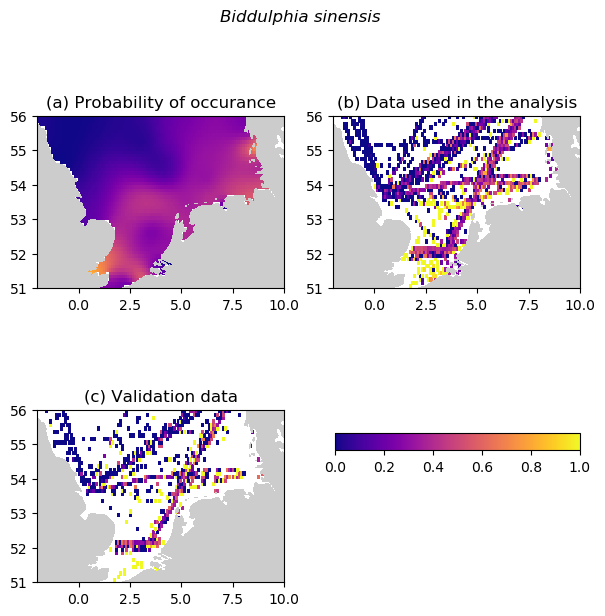

┌ Info: /home/abarth/tmp/Emodnet-Bio2020/Results/test/DIVAndNN_Biddulphia sinensis_interp.nc
└ @ Main /home/abarth/src/EMODnet-Biology-Interpolated-Maps/scripts/emodnet_bio_plot2.jl:107


In [22]:
include("../scripts/emodnet_bio_plot2.jl")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*